# PUI 2016 - HW9 - vsg247

## TIME SERIES ANALYSIS

## Goal: Find outliers, trends and periodicity in the MTA turnstile data
 

## INITIAL INSTRUCTIONS

### DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP (he will teach the Geopanda lecture).
You can get it from the github repo (use the download link to download it live in your notebook). 
It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


#### Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/21/2010 to 02/21/2014. 

The data are available to you as a *python data cube*. you can load it as 

```
np.load(“MTA_Fare.npy")
```

and you will end up with a python numpy array of 
shape (600, 23, 194)

#### note that the missing values are inputted as -1

if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the no.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```


as opposed to just 

use the no.nansum etc
```
np.mean(mtarides)
np.sum(mtarides)
```

In [207]:
import os
import numpy as np
import pylab as pl
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [208]:
#loading the data
os.system("wget https://github.com/fedhere/PUI2016_fb55/raw/master/HW9_fb55/MTA_Fare.npy")
os.system("mv MTA_Fare.npy " + os.getenv("PUIDATA"))

# storing in a numpy array
MTA = np.load(os.getenv("PUIDATA") + "/MTA_Fare.npy")


In [209]:
#checking if the data was loaded correctly
MTA.shape

(600, 23, 194)

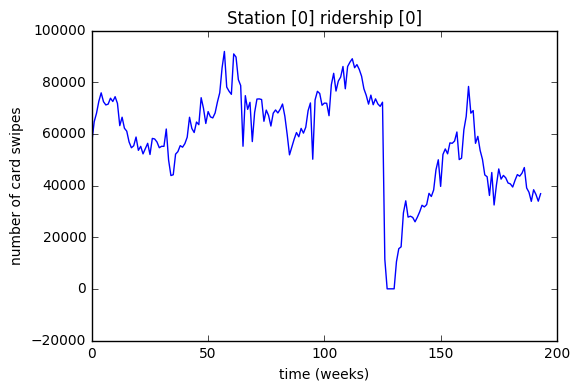

In [210]:
# plotting the the first time series to have a first look at the data
#tspan = np.arange(0,194, 1)
pl.plot(MTA[0, 0, :])
pl.xlabel('time (weeks)')
pl.ylabel('number of card swipes')
pl.title('Station [0] ridership [0]')
pl.show()

**FIGURE 01: Exploratory visualization of one of the time series (Station 0 and ridership 0).**

## TASKS

### Task 1: 
#### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
#### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.


### Task 2: 
#### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


### Task 3:
#### Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)


### EXTRA CREDIT: Cluster. 
#### Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
#### Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

#i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

```
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T
```

#removing empty light curves
```
tots = tots[tots.std(1)>0]
```

#with Kmeans you have to choose the number of clusters ahead km = 

```
KMeans(n_clusters=10)
```

#and standardize the lightcurves before clustering. Notice: standardize, not whiten! If you have done clustering before you may have whitened the data: removed the variance by "column", here you want to remove the variance by "row". We will discuss this in the clustering lecture. 
```
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
```

#then you can run:

```
km.fit(vals)
```

## TASK 1

From visual inspection of Figure 01, we can already see that the event with a significant drop happens around the week 130 of the series. Since the first week of the series is the week of 05/21/2010. We can already suspect that the event which caused that drop was probably Hurricane Sandy, which hit NYC in late October 2012. But let's see it more precisely through estabilishing a treshold at 3 sigma and looking for outliers.

In [211]:
# First checking how complete is the data set
fracNA = sum(MTA<0)/(600.0*23*194)

print "{0:d} missing values, representing {1:.2f}% of the data set.".format(sum(MTA<0), 100*fracNA)

649563 missing values, representing 24.26% of the data set.


In [212]:
MTA.dtype

dtype('int32')

In [213]:
#converting MTA to float
MTA = MTA.astype('float')
MTA.dtype

dtype('float64')

In [214]:
# transforming to NaN
for x in np.nditer(MTA, op_flags=['readwrite']):
    if x[...] == -1:
        x[...] = np.nan
    
# comparing it with the number of "-1"
sum(np.isnan(MTA))

649563

In [215]:
# since we know the event we are searching happened in the same week for all the time series, 
# we can simply look up for the event in the time series that represent the average of all our 600 x 23 time series

MTA_mean = np.nanmean(MTA, axis = (0,1))
MTA_mean.shape

(194,)

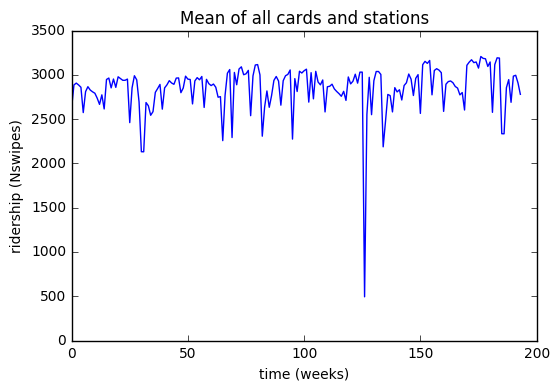

In [216]:
pl.plot(MTA_mean)
pl.xlabel('time (weeks)')
pl.ylabel('ridership (Nswipes)')
pl.title('Mean of all cards and stations')
pl.show()

**FIGURE 02: Time series of the mean ridership per card and per station, considering all card types and all stations. The event around week 125-130 can be easily detected by visual inspection.**

In [217]:
ride_mean = np.nanmean(MTA_mean)
ride_mean

2848.5770020190166

In [218]:
ride_sigma = np.nanstd(MTA_mean)
ride_sigma

269.22303004079009

In [219]:
tres = ride_mean - 3*ride_sigma
tres

2040.9079118966463

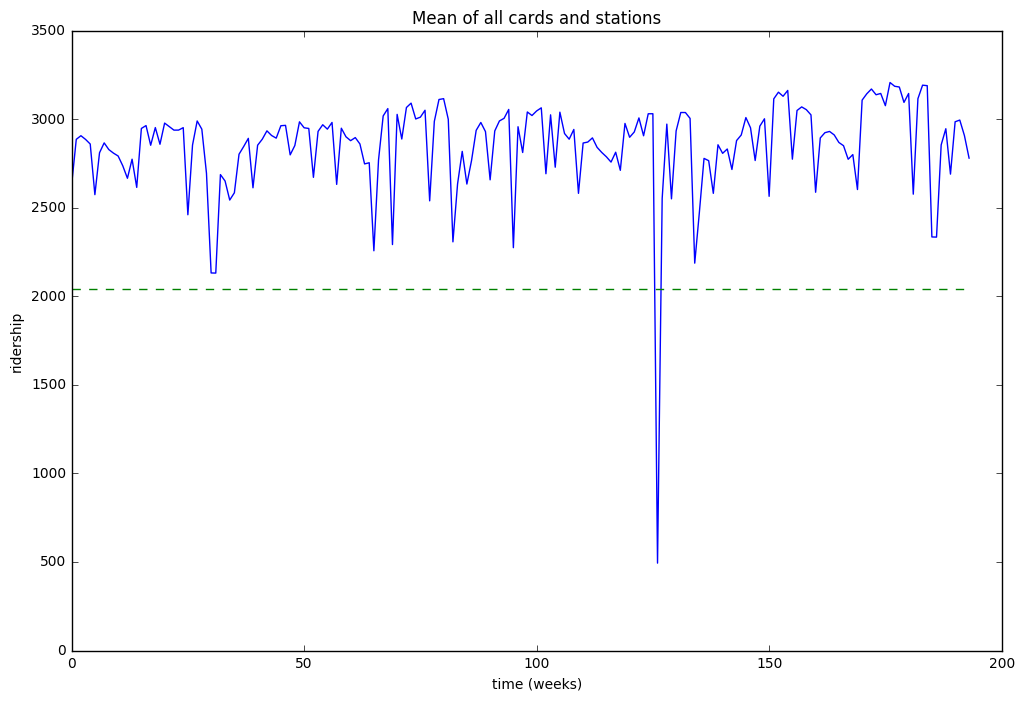

In [243]:
pl.plot(MTA_mean)
pl.plot(np.arange(0, 194, 1), tres*np.ones((194,)), '--')
pl.xlabel('time (weeks)')
pl.ylabel('ridership')
pl.title('Mean of all cards and stations')
pl.show()

**FIGURE 03: Time series of the mean ridership per card and per station, considering all card types and all stations. The dashed line represents the treshold of $3\sigma$ used to identify the event as an outliers in the series. The event happened on the week 126 of the analysed period and corresponds to the week when the Hurrycane Sandy has hit New York City.**

In [221]:
peak_loc = np.where(MTA_mean<tres)[0][0]
peak_loc

126

As explained in the instructions, the data refers to the period of 2010-05-21 to 2014-02-21.
But that actually that corresponds to a period of 1372 days, or 196 weeks and not 194. 
The data on the MTA website (http://web.mta.info/developers/turnstile.html) is organized in files named by the saturday of each week, so that the data on each of them corresponds to the period of 7 days that ends on the Friday immediately before the Saturday by which the file is named.

Since we know that the MTA stopped the subway operations on Sunday, October 28, 2012, at 11pm (https://en.wikipedia.org/wiki/Hurricane_Sandy), we can conclude that the first week for which we actually have the data (index = 0) is the week ending on the Saturday, June 5, 2010 (and the data there corresponds to the week that goes from May 29, 2010 to June 04, 2010). Also because the file for the week ending on May 29 is missing from the MTA website.    

In [222]:
# The significant drop happend on the week ending on the Saturday, November 3, 2012:
np.datetime64('2010-06-05') + peak_loc * 7

numpy.datetime64('2012-11-03')

## TASK 2

In [223]:
# taking the mean for each type of ridership
MTA_ridetypes = np.nanmean(MTA, axis = 0)
MTA_ridetypes.shape

(23, 194)

In [224]:
ridetypes = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [225]:
# replacing the outlier (Hurricane Sandy) by the mean of the adjacent values
MTA_ridetypes[:, peak_loc] = (MTA_ridetypes[:, peak_loc + 1] + MTA_ridetypes[:, peak_loc - 1])/2


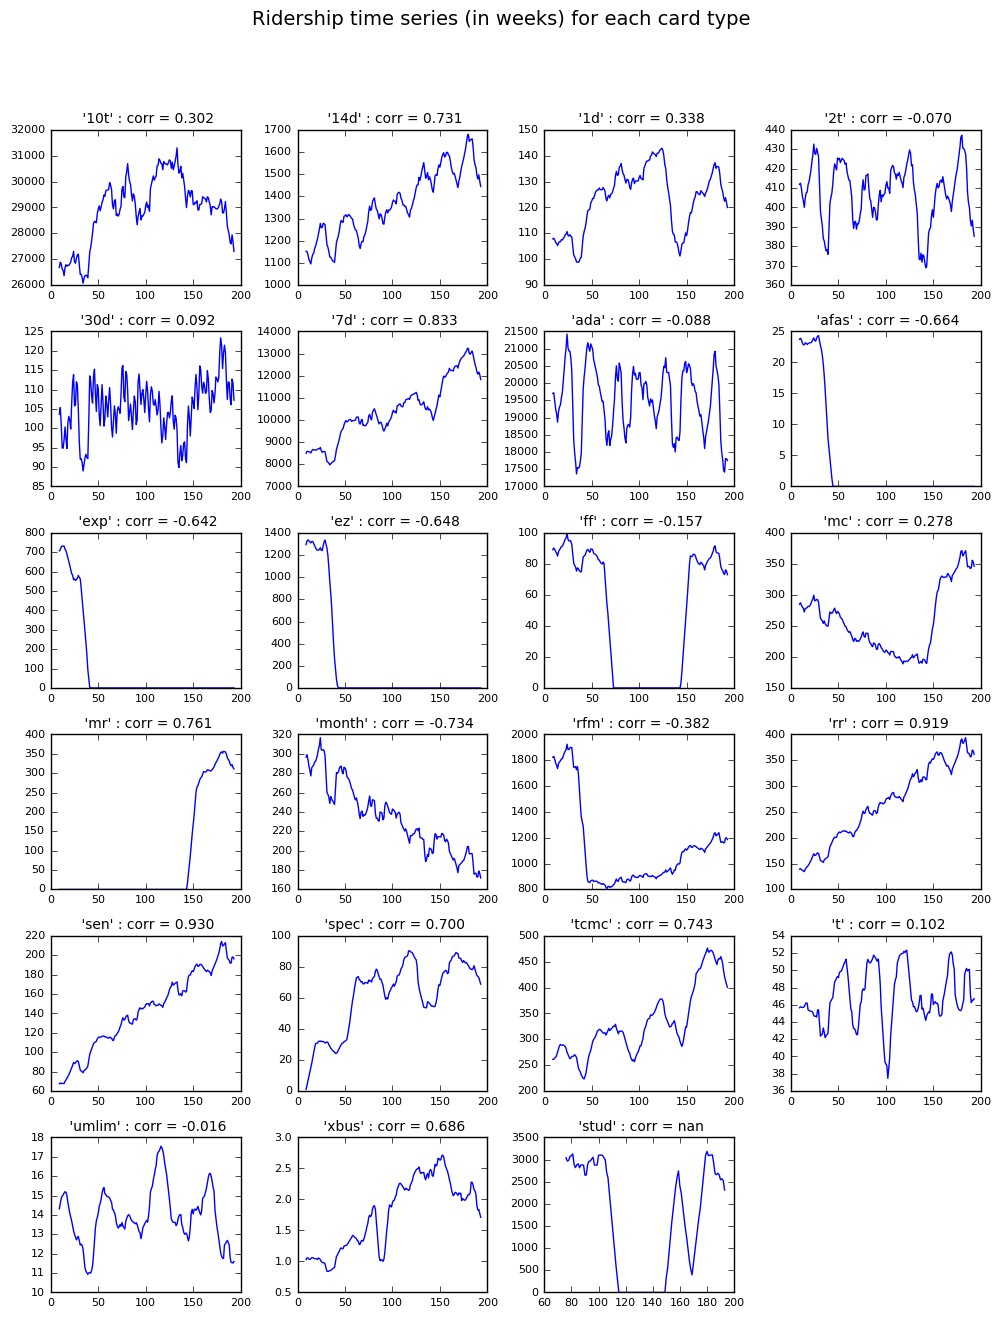

In [226]:
# plotting all the smoothed time series for visual inspection
smoothed = np.zeros_like(MTA_ridetypes)
pearson = np.zeros(23)
w=10

fig = figure(figsize(12, 15))
fig.subplots_adjust(hspace=.3, wspace=.3)
fig.suptitle("Ridership time series (in weeks) for each card type", fontsize=14)

for i in range(len(ridetypes)):
    smoothed[i] = np.array((pd.DataFrame(MTA_ridetypes[i]).rolling(window = w, center=False).mean()[0]))
    pearson[i] = np.corrcoef(MTA_ridetypes[i], np.arange(0, 194, 1))[0,1]
    pl.subplot(6,4,i+1)
    pl.plot(smoothed[i])
    pl.xticks(fontsize = 8)
    pl.yticks(fontsize = 8)
    pl.title(" '{0}' : corr = {1:.3f}".format(ridetypes[i], pearson[i]), fontsize=10)

**FIGURE 04: Time series of ridership for each card type indicating also the Pearsons correlation coefficent of ridership x time. By visual inspection we can see that the series that show a clear increas or decrease trend tend to have absolute values of correlation coefficients higher than 0.7. Nevertheless, there are series, like the 'mr' card, that have relativeley high correlation coefficient, but have actually a sudden rise from zero a little before week 150. That probably means that this type of card was activated only in the middle of this period. Therefore it will not be considered as a steadily increasing trend. The same applies to the cards 'exp' and 'ez', which were probably deactivated in the middle of this period.**

By visual inspection and supported by the correlation coefficient, we can see that the card types that are steadily increasing in popularity are the ones with corr >= 0.7:

    -'14d'
    -'7d'
    -'rr'
    -'sen'
    -'spec'
    -'tcmc'
    
And the ones that are steadily decreasing in popularity are the ones with corr <= -0.7:

    - 'month'


In [228]:
# listing the indices of the trends
ridetrends = [1, 5, 13, 15, 16, 17, 18]
n = 10

# calculating the variations in the period
usage_ratio = [(float(smoothed[i, -n:].mean()) / smoothed[i, w:w+n].mean()) - 1 for i in ridetrends]

# printing results
print ("Card types showing trends:\n")
print ("Card type     Variation     Pearson's corr")
for i in range(len(ridetrends)):
    print (" '{0}'          {1:.2f}%         {2:.3f}".format(ridetypes[ridetrends][i],
                                                     usage_ratio[i]*100, pearson[ridetrends][i]))


Card types showing trends:

Card type     Variation     Pearson's corr
 '14d'          34.98%         0.731
 '7d'          44.14%         0.833
 'month'          -38.10%         -0.734
 'rr'          161.55%         0.919
 'sen'          181.19%         0.930
 'spec'          348.47%         0.700
 'tcmc'          56.93%         0.743


Alternatively we could also fit a line to each of this time series and compare the slope coefficients to see which one was the steepest.

## TASK 3

In [229]:
# getting the sum on each station, including all card types

MTA_stations = np.nansum(MTA, axis = 1)
MTA_stations.shape

(600, 194)

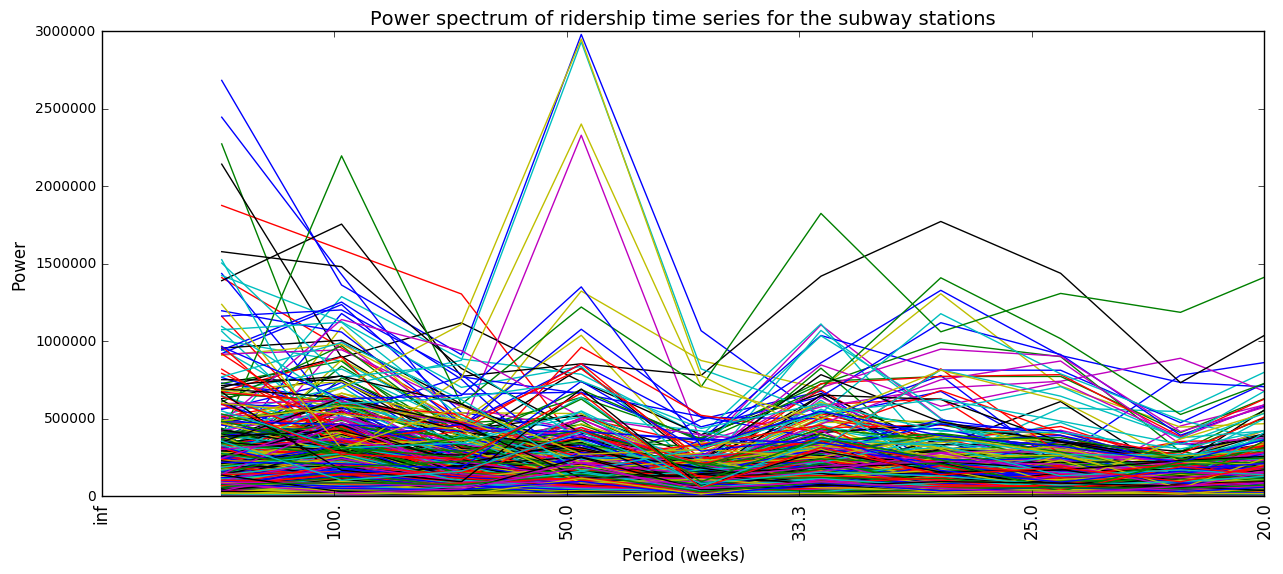

In [239]:
N = 194
d = 1.0

f = np.abs(np.fft.rfft(MTA_stations))
allperiods = np.abs(np.fft.rfftfreq(N, d))

fig2 = pl.figure(figsize = (15, 6))
ax = fig2.add_subplot(111)

ax.plot(allperiods[1:], f.T[1:])
ax.set_xlim(0, 0.05)
ax.set_xticklabels([ "%.4s"%(1/w) for w in ax.get_xticks()], fontsize=12, rotation=90)
pl.xlabel('Period (weeks)', fontsize=12)
pl.ylabel('Power',fontsize=12)
pl.title('Power spectrum of ridership time series for the subway stations',fontsize=14)
pl.show()

** FIGURE 05: Power Spectrum of the time series corresponding to each of the 600 subway stations. The plot was zoomed in to the region where the periods correspond to N/1, N/2, ... , N/9 because we want to identify which are the series that have an annual priodicity, corresponding to a period of 52 weeks. Since the Discrete Fourier Transform allow us to evaluate the periodicity of the series in periods that correspond to the division of N (number of observations = 194) by integers, the closest period to the 52 weeks that we have to investigate is the one corresponding to N/4 = 48.5. By selecting the four series that have the highest peak on that period, we can find the ones that show the most prominent periodic trend on an annual period.**

In [237]:
f.shape

(600, 98)

In [238]:
st = []
annual_period = f[:,4]
for i in range(4):
    st.append(np.argmax(annual_period))
    annual_period[np.argmax(annual_period)] = 0

print st

[0, 194, 150, 327]


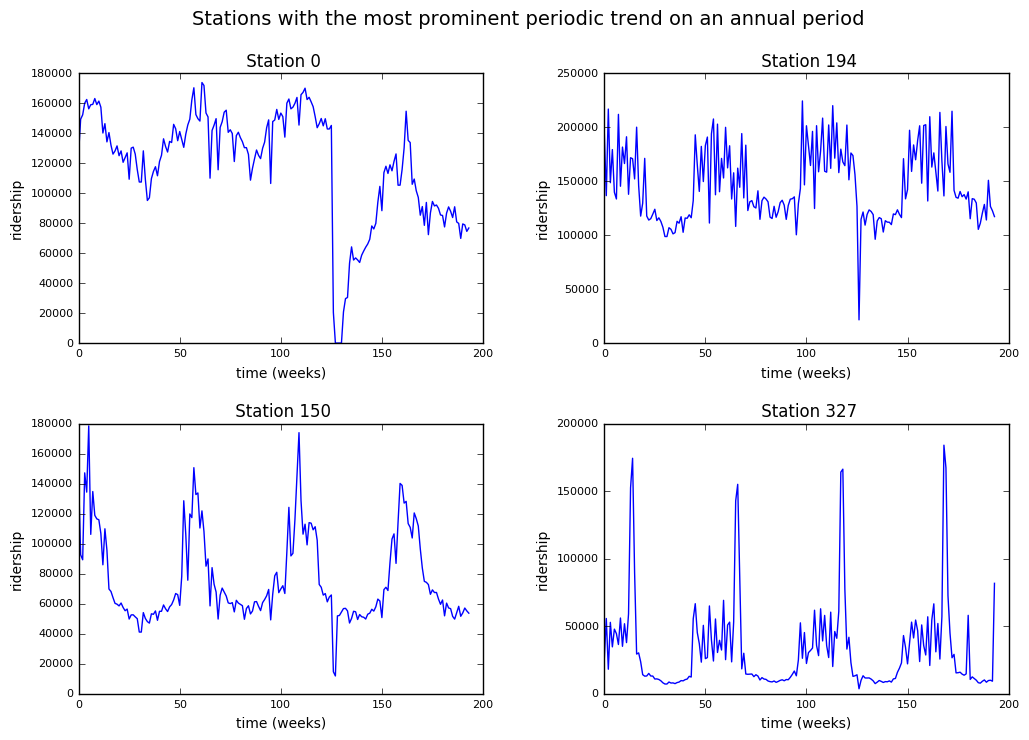

In [245]:
# plotting the time series with the most prominent periodic trend on an annual period

fig3 = figure(figsize(12, 8))
fig3.subplots_adjust(hspace=.3, wspace=.3)
fig3.suptitle("Stations with the most prominent periodic trend on an annual period", fontsize=14)

for i in range(4):
    pl.subplot(2,2,i+1)
    pl.plot(MTA_stations[st[i],:])
    pl.xticks(fontsize = 8)
    pl.yticks(fontsize = 8)
    pl.xlabel('time (weeks)')
    pl.ylabel('ridership')
    pl.title(" Station {0}".format(st[i]))

** FIGURE 06: Stations with the most prominent periodic trend on an annual period. We can observe that although all the four station have an annual periodic trend, and show a higher ridership around summer period, the individual cycle can be considerably different for each station. It is particularly interesting to observe the high peak at the end of the summer for station 327, the rather noisy square-shaped wave for station 194 and the triangular-shaped wave for stations 150 and finally the more senoidal behavior of station 0 (except from the outlier for Hurricane Sandy).**

In [259]:
# checking where exactly the highest peak stays for each station
peaks = {}
for station in st:
    peaks[station] = np.datetime64('2010-06-05') + np.argmax(MTA_stations[station,:]) * 7 
    print ("{0:3d} : {1:5d} : {2}".format(station, np.argmax(MTA_stations[station,:]), peaks[station]))

  0 :    61 : 2011-08-06
194 :    98 : 2012-04-21
150 :     5 : 2010-07-10
327 :   168 : 2013-08-24


Station 0 has its ridership peak around the first week of August. I could not find any specific event that could be related to that, but the peak is also not very prominent compared to rest of the summer.

Station 194 has a relatively flat (although noisy) behavior in the summer, so the exact day of the peak does not say much. 

Station 150 has its peak around the week of the 4th of July, so the occurence of the peak could be related to that. For instance the station could be close to where people go to celebrate that day. 

Station 327 has a consistent very high peak (that represents a 3 fold increase in the normal summer ridership) in one of the last weeks of the summer. That could be related to the Labor day holiday, but it seems to happen a week to early for that. It is more likely that there is some big event close to that station every year in the end of August. 

All four stations present a prominent annual periodic trend and all of them have higher ridership in the summer. One reason that could explain that is if they are all close to parks that people visit more in the summer. Besides that, as mentioned above, stations 150 and 327 possibly have some more special event that is related to their annual peak in ridership.  

## EXTRA CREDIT

In [260]:
# Clustering by K-means in 10 clusters

# flattening the data
MTA_flat = MTA.reshape([600*23, -1])

In [261]:
MTA_flat.shape

(13800, 194)

In [262]:
# replacing outlier
MTA_flat[:, peak_loc] = (MTA_flat[:, peak_loc + 1] + MTA_flat[:, peak_loc - 1])/2

In [263]:
# standardizing the ridership
MTA_std = ((MTA_flat.T - np.nanmean(MTA_flat, axis = 1))/ np.nanstd(MTA_flat, axis = 1)).T

print MTA_std.shape

#pl.plot(MTA_std[0])

(13800, 194)


In [264]:
# replacing nans by 0
MTA_std[np.isnan(MTA_std)] = 0

In [189]:
# selecting the number of clusters

# X=MTA_std
# range_n_clusters = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
# for n_clusters in range_n_clusters:
#     km = KMeans(n_clusters=n_clusters, random_state=324)
#     cluster_labels = km.fit_predict(X)
#     silhouette_avg = silhouette_score(X, cluster_labels)
#     print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =5, the average silhouette_score is :0.406192804952
For n_clusters =6, the average silhouette_score is :0.403299700528
For n_clusters =7, the average silhouette_score is :0.416493849576
For n_clusters =8, the average silhouette_score is :0.426761664994
For n_clusters =9, the average silhouette_score is :0.433055479691
For n_clusters =10, the average silhouette_score is :0.433667326566
For n_clusters =11, the average silhouette_score is :0.405377037548
For n_clusters =12, the average silhouette_score is :0.409804413109
For n_clusters =13, the average silhouette_score is :0.408670913685
For n_clusters =14, the average silhouette_score is :0.410157252627


For n_clusters =5, the average silhouette_score is :0.406192804952

For n_clusters =6, the average silhouette_score is :0.403299700528

For n_clusters =7, the average silhouette_score is :0.416493849576

For n_clusters =8, the average silhouette_score is :0.426761664994

For n_clusters =9, the average silhouette_score is :0.433055479691

For n_clusters =10, the average silhouette_score is :0.433667326566

For n_clusters =11, the average silhouette_score is :0.405377037548

For n_clusters =12, the average silhouette_score is :0.409804413109

For n_clusters =13, the average silhouette_score is :0.408670913685

For n_clusters =14, the average silhouette_score is :0.410157252627

In [190]:
# X=MTA_std
# range_n_clusters = [15, 16, 17, 18, 19, 20, 25, 30, 35, 40]
# for n_clusters in range_n_clusters:
#     km = KMeans(n_clusters=n_clusters, random_state=324)
#     cluster_labels = km.fit_predict(X)
#     silhouette_avg = silhouette_score(X, cluster_labels)
#     print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =15, the average silhouette_score is :0.410555702642
For n_clusters =16, the average silhouette_score is :0.409814383056
For n_clusters =17, the average silhouette_score is :0.406553400801
For n_clusters =18, the average silhouette_score is :0.409120291756
For n_clusters =19, the average silhouette_score is :0.408026754276
For n_clusters =20, the average silhouette_score is :0.408945982869
For n_clusters =25, the average silhouette_score is :0.41334721341
For n_clusters =30, the average silhouette_score is :0.398287417782
For n_clusters =35, the average silhouette_score is :0.394085383089
For n_clusters =40, the average silhouette_score is :0.41601300979


For n_clusters =15, the average silhouette_score is :0.410555702642

For n_clusters =16, the average silhouette_score is :0.409814383056

For n_clusters =17, the average silhouette_score is :0.406553400801

For n_clusters =18, the average silhouette_score is :0.409120291756

For n_clusters =19, the average silhouette_score is :0.408026754276

For n_clusters =20, the average silhouette_score is :0.408945982869

For n_clusters =25, the average silhouette_score is :0.41334721341

For n_clusters =30, the average silhouette_score is :0.398287417782

For n_clusters =35, the average silhouette_score is :0.394085383089

For n_clusters =40, the average silhouette_score is :0.41601300979

In [191]:
#From the silhouette method we can identify that the best number of clusters is k = 10.

km = KMeans(n_clusters=10, random_state=324)
lbl_kmeans10 = km.fit_predict(X)

In [193]:
# number of series on each cluster
np.unique(lbl_kmeans10, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([5696, 1730,  474,  874,  641,  466, 1725, 1001,  617,  576]))

We can see that by clustering with k=10 we get one much bigger cluster, and other 9 more similar ones.
In order to investigate better this results and identify which stations tend to fall in the same clusters and which card types tend to fall in the same cluster we would have to reshape the array and do some further analysis on it.  

In [267]:
# Sample of the clustering results for the first 10 stations and first 5 card types
lbl_kmeans10.reshape([600, 23])[:10, :5]

array([[8, 3, 8, 8, 8],
       [0, 0, 0, 0, 0],
       [3, 6, 6, 8, 6],
       [3, 6, 6, 8, 0],
       [3, 6, 3, 8, 0],
       [3, 6, 3, 3, 7],
       [3, 6, 8, 0, 9],
       [3, 6, 3, 8, 0],
       [3, 6, 3, 2, 3],
       [3, 6, 3, 4, 4]], dtype=int32)

Alternatively, we can do PCA before clustering.

In [268]:
pca = PCA(0.90)
Xproj = pca.fit_transform(X)

Xproj.shape

(13800, 25)

In [202]:
# # Fitting the PCA without reducing the dimensions, i.e. finding the eigenvectors for the Linear Transformation.  
# pca = PCA(64)
# pca.fit(X)

# # Plotting the explained variance for each of the eigenvectors 
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, 65), pca.explained_variance_ratio_, 'bo')
# plt.xlabel('eigenvector indexes', fontsize='x-large')
# plt.ylabel('explained variance', fontsize ='x-large')
# plt.show()

In [203]:
sum(pca.explained_variance_ratio_)

0.90060183775858593

In [204]:
# # selecting the number of clusters

# X=Xproj
# range_n_clusters = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
# for n_clusters in range_n_clusters:
#     km = KMeans(n_clusters=n_clusters, random_state=324)
#     cluster_labels = km.fit_predict(X)
#     silhouette_avg = silhouette_score(X, cluster_labels)
#     print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =5, the average silhouette_score is :0.430466432045
For n_clusters =6, the average silhouette_score is :0.448548167939
For n_clusters =7, the average silhouette_score is :0.44745025709
For n_clusters =8, the average silhouette_score is :0.45806533401
For n_clusters =9, the average silhouette_score is :0.46430466857
For n_clusters =10, the average silhouette_score is :0.465205059375
For n_clusters =11, the average silhouette_score is :0.466806409717
For n_clusters =12, the average silhouette_score is :0.441840237778
For n_clusters =13, the average silhouette_score is :0.466414885809
For n_clusters =14, the average silhouette_score is :0.441935612693


For n_clusters =5, the average silhouette_score is :0.430466432045

For n_clusters =6, the average silhouette_score is :0.448548167939

For n_clusters =7, the average silhouette_score is :0.44745025709

For n_clusters =8, the average silhouette_score is :0.45806533401

For n_clusters =9, the average silhouette_score is :0.46430466857

For n_clusters =10, the average silhouette_score is :0.465205059375

For n_clusters =11, the average silhouette_score is :0.466806409717

For n_clusters =12, the average silhouette_score is :0.441840237778

For n_clusters =13, the average silhouette_score is :0.466414885809

For n_clusters =14, the average silhouette_score is :0.441935612693

In [271]:
# On the projected space, the silhouette method, the best number of clusters is k = 11. But k = 10 is also basically as good.
# In order to compare the clustering with the previous one, we can use the same k as before: k=10. 

km = KMeans(n_clusters=10, random_state=324)
lbl_kmeans10_pca90 = km.fit_predict(Xproj)

In [272]:
# number of series on each cluster
np.unique(lbl_kmeans10_pca90, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([5696, 1729,  646,  475,  578,  618, 1721, 1003,  868,  466]))

Similar to the clustering without PCA, for the clustering after PCA we get one much bigger cluster, and other 9 more similar ones. So the PCA does not seem to have improved the analysis.
In order to proceed with it, we could probably continue to investigate the clustering results without the PCA. 

In [284]:
# Comparing the results with and without PCA
print lbl_kmeans10_pca90.reshape([600, 23])[:10, :5] 
print ""
print lbl_kmeans10.reshape([600, 23])[:10, :5]

[[5 8 5 5 5]
 [0 0 0 0 0]
 [8 6 6 5 6]
 [8 6 6 5 0]
 [8 6 8 5 0]
 [8 6 8 8 7]
 [8 6 5 0 4]
 [8 6 8 5 0]
 [8 6 8 3 8]
 [8 6 8 2 2]]

[[8 3 8 8 8]
 [0 0 0 0 0]
 [3 6 6 8 6]
 [3 6 6 8 0]
 [3 6 3 8 0]
 [3 6 3 3 7]
 [3 6 8 0 9]
 [3 6 3 8 0]
 [3 6 3 2 3]
 [3 6 3 4 4]]
